# My Udacity Data Scientist Project 1: "predict ticket work"

## import modules and functions

In [1]:
import os
import pandas            as pd
import numpy             as np
import xgboost           as xgb
import matplotlib.pyplot as plt

import swifter # parallelizes "apply()"

from jira import JIRA
from read_jira_data           import download_data
from nlp_data_preprocessing   import make_nlp_string

from sklearn.model_selection  import train_test_split
from sklearn.metrics          import mean_squared_error, explained_variance_score

from text_feature_extraction  import extract_tfidf_features
from nlp_data_preprocessing   import categorical_to_quantitative

from xgb_analysis             import examine_feature_impact


import re    # these (and below) are needed for the "make_nlp_string"-function (see below)
import nltk
for resource in ["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger", "snowball_data"]:
    try:
        nltk.data.find('tokenizers/' + resource)
    except LookupError:
        nltk.download(resource, quiet = True)
from nltk.tokenize      import word_tokenize
from nltk.corpus        import stopwords
from nltk.stem.snowball import SnowballStemmer
import langdetect

## summary
The following notebook will (1) provide insights into some technical methods and (2) provide answers to business-related questions in the area of (software) ticket work estimation.

Insights from the technical side:
1. A method for bulk-downloading JIRA ticket data from a jira server
2. Methods for  preprocessing _language_ data so that it can be used for data science modeling
   a) Cleaning strings and stripping non-insightful data like delimiters and stopwords
   b) Word-stemming
   c) Computing TFIDF (term frequency–inverse document frequency) features for a set of string (documents)
3. A simple method for interpreting the impact that a certain keyword has on the final prediction

Insights for the business-side
1. What are the average times that a "New Feature", "Bug" (etc) spends in implementation (i.e. status "in progress")?
2. Is it possible to estimate the time spent "in progress" from analyzing the summary and description of a ticket?
3. Which words in the description make up for large / small durations?

## 1. gather data
In the following, the JIRA ticket data is downloaded from the JFrog jira server.
The data is written into a comma-separated file, which can easily be loaded into a pandas dataframe

In [2]:
str_output_file = "data_jfrog.csv"

if not os.path.exists(str_output_file):
    
    str_your_username = "" # insert your login name here
    str_your_password = "" # insert your password here
    
    jira = JIRA( basic_auth=(str_your_username, str_your_password), 
                 options={'server': 'https://www.jfrog.com/jira'})
    
    list_of_jira_project_prefixes = ['RTFACT']
    
    str_status_to_look_for = 'In Progress'
    
    download_data(jira, 
                  str_output_file, 
                  list_of_jira_project_prefixes, 
                  str_status_to_look_for)

Load the data into a Pandas dataframe and strip (leading/trailing) whitespaces from column names and remove all (leading/trailing) whitespaces from the 'string' entries in the dataframe

In [3]:
df = pd.read_csv('./' + str_output_file)

df.columns = [s.strip() for s in df.columns]

strip_string_lambda = lambda elem: elem.strip()
for columnName in list(df.select_dtypes(include=['object']).columns):
    df[columnName] = df[columnName].apply(strip_string_lambda)

## 2. exploratory data analysis
Overall, there are ~2200 valid entries in the dataset (i.e. the target value "y" is non-zero):

In [4]:
print(df[(df['timeInProgress']  > 0.0001)]['issuetype'].value_counts().sum())

2258


Grouped by the (JIRA) issue type, their counts are distributed as follows:

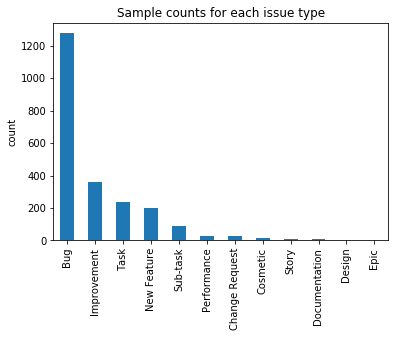

In [12]:
nonzero_entries = df['timeInProgress'] != 0.0

axes = df[nonzero_entries]['issuetype'].value_counts().plot.bar()

plt.title("Sample counts for each issue type")
axes.set_ylabel("count");

Note the high count of "Bug"-tickets which account for almost 60% of the entries

### outlier removal
To account for outliers, the 4% largest values are removed. This can be accolplished easily, by computingthe 96%-quantile in Pandas

In [17]:
valid_entires = ((df['timeInProgress']  > 0.0001) & (df['timeInProgress']  < df["timeInProgress"].quantile(q=0.96)))

### target value grouped by issue type
For those valid entries, the target value (time in progress) is distributed as follows among the different issue types:

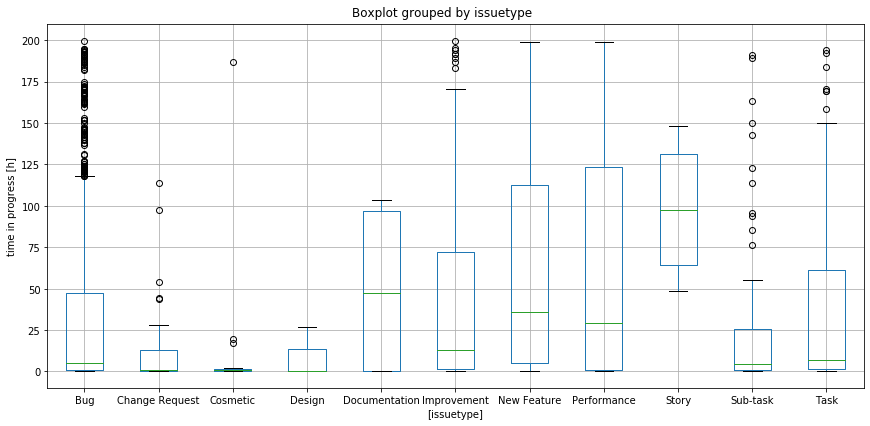

In [18]:
data        = df[valid_entires][['issuetype', 'timeInProgress']]
axes = data.boxplot(by='issuetype', figsize=(12, 6))
plt.tight_layout()
plt.title("");
axes.set_ylabel("time in progress [h]");

### average time in doing (by ticket type)
besides the quantiles shown in the plot above, you can find the mean and std deviation values below. It's noteable that the standard deviation values are relatively close together.

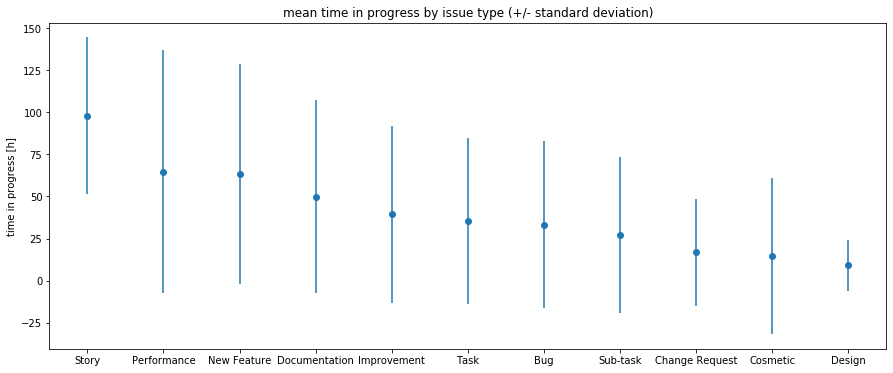

In [38]:
data        = df[((df['timeInProgress']  > 0.0001) & (df['timeInProgress']  < 200.0))][['issuetype', 'timeInProgress']]
tmp         = pd.concat( [data.groupby(['issuetype']).mean(), data.groupby(['issuetype']).std()], axis=1 )
tmp.columns = ['mean time in progress [h]', 'standard deviation']
tmp         = tmp.sort_values(by = 'mean time in progress [h]', ascending=False)

f = plt.figure(figsize=(15, 6))
plt.errorbar(x=tmp.index, y=tmp['mean time in progress [h]'], yerr=tmp['standard deviation'], fmt='o')
plt.title("mean time in progress by issue type (+/- standard deviation)")
plt.ylabel("time in progress [h]")

plt.show()

## 3. clean
Apply "make_nlp_string" to _all_ descriptions and all summaries. In this way, the features will later be extracted over the whole dataset (even though bist of the entries will be ignored, since the target value is 0.0).
I will explain this step in greater detail, since it's an important step for preparing the string data.

In [39]:
lambda_nlp_string = lambda string: make_nlp_string( string )
df["description"] = df["description"].swifter.apply(lambda_nlp_string)
df["summary"]     = df["summary"].swifter.apply(lambda_nlp_string)

### Detailed explanation of ``make_nlp_string``

The function serves for preprocessing a document so that useless data is eliminated. This concerns:

    1) remove line endings                 (\n, \r)
    2) remove consecutive white spaces     (e.g. "   ")
    3) remove special characters           (only keep: [a-zA-ZäöüÄÖÜß ])
    4) remove stop words                   (e.g. "the", "a", etc)
    5) performs word stemming / lemmatization (e.g. "make", "made", "making" -> "make"]

In [40]:
def make_nlp_string( str_document ):
    """preprocessing of a document

    1) removes line endings
    2) removes consecutive white spaces
    3) removes special characters
    4) removes stop words
    5) performs word stemming / lemmatization

    Parameters
    ----------
    str_document : string
        string of possibly several sentences that form a document
        
    Returns
    -------
    whitespace-delimited string of the preprocessed words
    
    """    
    
    str_language = "english"
    
    try:
        tmp = langdetect.detect( str_document )
        if tmp == "de":
            str_language = "german"
        else:
            str_language = "english"
    except:
        pass #langdetect not successful. Fallback: 'english'
    
        
    # remove line endings
    string_tmp = str_document.replace("\n", " ").replace("\r", " ")
    
    # remove non-alphanumeric characters
    string_tmp = re.sub('[^a-zA-ZäöüÄÖÜß ]', ' ', string_tmp)
    
    # remove consecutive whitespaces
    string_tmp = re.sub(' +', ' ', string_tmp)
    
    # make lower case
    string_tmp = string_tmp.lower()
    
    # break into words
    word_tokens = [w for w in word_tokenize(string_tmp) if len(w) > 1]
    
    # remove stop words
    stop_words = stopwords.words( str_language )
    
    # break into individual words
    listWords = [w for w in word_tokens if not w in stop_words]
    
    # perform word stemming / lemmatization    
    if str_language == 'german':
        stemmer = SnowballStemmer("german")    
    elif str_language == 'english':
        stemmer = SnowballStemmer("english")

    for idx, word in enumerate(listWords):
        listWords[idx] = stemmer.stem( listWords[idx] )
             
    return " ".join(listWords)

## 4. analyze
Extract TFIDF features and convert the categorical entries into quantitative ones

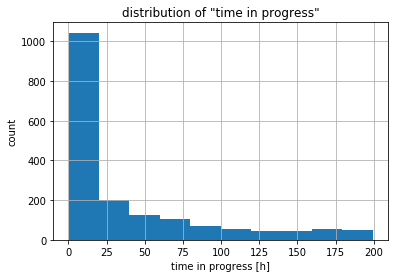

In [41]:
nMaxFeatures_Description     = 20
nMaxFeatures_Summary         = 20

df_tfidf_description         = extract_tfidf_features(df["description"], nMaxFeatures_Description)
df_tfidf_description.columns = ["description_" + s for s in df_tfidf_description.columns]
df_tfidf_description.index   = np.arange(0, len(df_tfidf_description))

df_tfidf_summary             = extract_tfidf_features(df["summary"], nMaxFeatures_Summary)
df_tfidf_summary.columns     = ["summary_" + s for s in df_tfidf_summary.columns]
df_tfidf_summary.index       = np.arange(0, len(df_tfidf_summary))

df_tickettype                = categorical_to_quantitative( df["issuetype"], "issuetype")

df_tickettype.index          = np.arange(0, len(df_tickettype))

finalDataFrame = pd.concat([df["timeInProgress"],
                            df_tfidf_description,
                            df_tfidf_summary,
                            df_tickettype],
                            axis=1)
if True:
    # note, that the invalid data is dropped now so that the words are included in the TFIDF-features
    idx_keep             = (finalDataFrame["timeInProgress"] > 0.0) & \
                           (finalDataFrame["timeInProgress"] < 200.0)
    finalDataFrame       = finalDataFrame[idx_keep]
    finalDataFrame.index = np.arange(0, len(finalDataFrame))

finalDataFrame["timeInProgress"].hist()
plt.xlabel('time in progress [h]')
plt.ylabel('count')
plt.title('distribution of "time in progress"')

if True:

    mean_y = finalDataFrame['timeInProgress'].mean()
    std_y  = finalDataFrame['timeInProgress'].std()

    finalDataFrame_normalized = (finalDataFrame-finalDataFrame.mean()) / finalDataFrame.std()
    
else:
    mean_y = 0.0
    std_y  = 1.0
    
    finalDataFrame_normalized = finalDataFrame

## 5. model
Train gradient boosted trees :)

explained variance score on the TRAIN set: 0.446
explained variance score on the TEST  set: -0.112
RMSE on the train set: 39.37 [hours]
RMSE on the test  set: 51.74 [hours]


Text(0.5, 0, 'estimated time [h]')

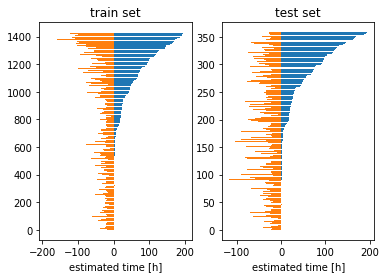

In [45]:
np.random.seed(42)

X_train, X_test, y_train, y_test = \
    train_test_split( 
        finalDataFrame_normalized.drop(columns = ['timeInProgress']), 
        finalDataFrame_normalized['timeInProgress'], 
        test_size=0.2, 
        random_state=42)

        
alpha                    = 1.0
#lambda = 10
colsample_bytree         = 0.8
colsample_bylevel        = 0.7
colsample_bynode         = 1.0
learning_rate            = 0.2
max_depth                = 5
n_estimators             = 50


xg_reg = xgb.XGBRegressor(objective         ='reg:squarederror', 
                          colsample_bytree  = colsample_bytree, 
                          colsample_bylevel = colsample_bylevel,
                          colsample_bynode  = colsample_bynode,
                          learning_rate     = learning_rate,
                          max_depth         = max_depth, 
                          alpha             = alpha, 
                          n_estimators      = n_estimators,
                          random_state      = 42)

xg_reg.fit(X_train, y_train)

train_mse_rescaled = mean_squared_error(y_train, xg_reg.predict(X_train)) * std_y * std_y
test_mse_rescaled  = mean_squared_error(y_test,  xg_reg.predict(X_test)) * std_y * std_y

print("explained variance score on the TRAIN set: %5.3f"%(explained_variance_score(y_train, xg_reg.predict(X_train))))
print("explained variance score on the TEST  set: %5.3f"%(explained_variance_score(y_test, xg_reg.predict(X_test))))

print("RMSE on the train set: %5.2f [hours]"%(np.sqrt(train_mse_rescaled)))
print("RMSE on the test  set: %5.2f [hours]"%(np.sqrt(test_mse_rescaled)))



train_predictions = mean_y + xg_reg.predict(X_train) * std_y
train_truth       = mean_y + y_train                 * std_y
test_predictions  = mean_y + xg_reg.predict(X_test)  * std_y
test_truth        = mean_y + y_test                  * std_y

f = plt.figure()

plt.subplot(1,2,1)
plt.title("train set")
idx = np.argsort( train_truth.values ).astype(int)
plt.barh(y=np.arange(0, len(train_truth.values)), width=train_truth.values[idx])
plt.barh(y=np.arange(0, len(train_predictions)),  width=train_predictions[idx]*(-1))
plt.xlabel("estimated time [h]")

plt.subplot(1,2,2)
plt.title("test set")
idx = np.argsort( test_truth.values ).astype(int)
plt.barh(y=np.arange(0, len(test_truth.values)), width=test_truth.values[idx])
plt.barh(y=np.arange(0, len(test_predictions)),  width=test_predictions[idx]*(-1))
plt.xlabel("estimated time [h]")



## 6.1 visualize estimation error

mean absolute error on the TRAIN set: -0.04 +/- 39.38
mean absolute error on the TEST  set:  5.02 +/- 51.57


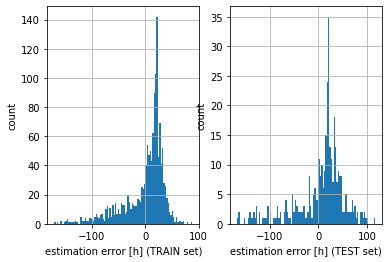

In [46]:
fig = plt.figure(2)
plt.subplot(1,2,1)
plt.xlabel('estimation error [h] (TRAIN set)')
plt.ylabel('count')
df_result = pd.Series((xg_reg.predict(X_train) * std_y) - (y_train * std_y).values)
print( "mean absolute error on the TRAIN set: %5.2f +/- %5.2f"%(df_result.mean(), df_result.std()))

df_result.hist(bins = 100)
plt.subplot(1,2,2)
plt.xlabel('estimation error [h] (TEST set)')
plt.ylabel('count')
df_result = pd.Series((xg_reg.predict(X_test) * std_y) - (y_test * std_y).values)
print( "mean absolute error on the TEST  set: %5.2f +/- %5.2f"%(df_result.mean(), df_result.std()))

df_result.hist(bins = 100)
plt.draw()

## 6. analyze keyword impact

In [47]:
feature_labels_order1, average_impact_order1, total_impact_order1 = examine_feature_impact( xg_reg, 
                                                                                           X_train, 
                                                                                           y_train, 
                                                                                           order = 1 )


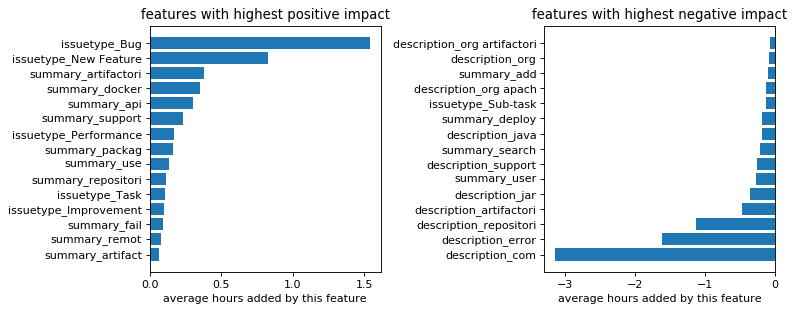

In [49]:
sorted_idx = np.argsort(average_impact_order1).astype(int)

fig=plt.figure(figsize=(10, 4), dpi= 80)

plt.subplot(1,2,1)
plt.title('features with highest positive impact')
top = sorted_idx[-15:]
pos = np.arange(top.shape[0]) + .5
plt.barh(pos, np.array(average_impact_order1)[top], align='center')
plt.yticks(pos, np.array(feature_labels_order1)[top])
plt.xlabel('average hours added by this feature')


plt.subplot(1,2,2)
plt.title('features with highest negative impact')
bottom = sorted_idx[:15]
pos = np.arange(bottom.shape[0]) + .5
plt.barh(pos, np.array(average_impact_order1)[bottom], align='center')
plt.yticks(pos, np.array(feature_labels_order1)[bottom])
plt.xlabel('average hours added by this feature')

plt.tight_layout()

### impact of combinations of words

In [50]:
feature_labels_order2, average_impact_order2, total_impact_order2 = examine_feature_impact( xg_reg, 
                                                                                           X_train, 
                                                                                           y_train, 
                                                                                           order = 2 )

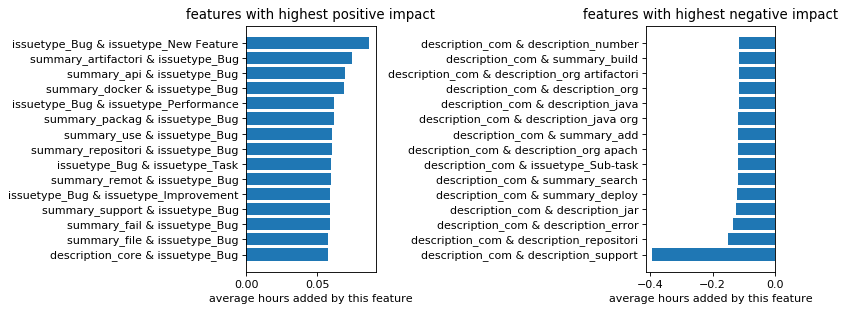

In [51]:
sorted_idx = np.argsort(average_impact_order2).astype(int)

fig=plt.figure(figsize=(10, 4), dpi= 80)

plt.subplot(1,2,1)
plt.title('features with highest positive impact')
top = sorted_idx[-15:]
pos = np.arange(top.shape[0]) + .5
plt.barh(pos, np.array(average_impact_order2)[top], align='center')
plt.yticks(pos, np.array(feature_labels_order2)[top])
plt.xlabel('average hours added by this feature')


plt.subplot(1,2,2)
plt.title('features with highest negative impact')
bottom = sorted_idx[:15]
pos = np.arange(bottom.shape[0]) + .5
plt.barh(pos, np.array(average_impact_order2)[bottom], align='center')
plt.yticks(pos, np.array(feature_labels_order2)[bottom])
plt.xlabel('average hours added by this feature')


plt.tight_layout()

## answers to the questions asked

1. What are the average times that a "New Feature", "Bug" (etc) spends in implementation (i.e. status "in progress")?

As the figure below shows, the largest average time is spent on "Stories" with around 100h in progress. Improvements, Tasks and Bugs are in the middle with 25...50h spent in progress. The least amount of work is usually required for Cosmetic and Design issues, which usually take less that 25h to complete.

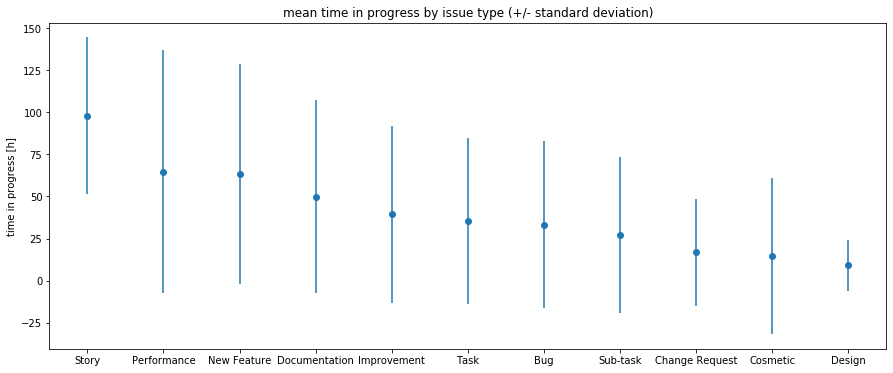

In [53]:
data        = df[((df['timeInProgress']  > 0.0001) & (df['timeInProgress']  < 200.0))][['issuetype', 'timeInProgress']]
tmp         = pd.concat( [data.groupby(['issuetype']).mean(), data.groupby(['issuetype']).std()], axis=1 )
tmp.columns = ['mean time in progress [h]', 'standard deviation']
tmp         = tmp.sort_values(by = 'mean time in progress [h]', ascending=False)

f = plt.figure(figsize=(15, 6))
plt.errorbar(x=tmp.index, y=tmp['mean time in progress [h]'], yerr=tmp['standard deviation'], fmt='o')
plt.title("mean time in progress by issue type (+/- standard deviation)")
plt.ylabel("time in progress [h]")

plt.show()

2. Is it possible to estimate the time spent "in progress" from analyzing the summary and description of a ticket?

Well... somewhat. When I started tuning some of the parameters, I ended up with a highly overfitted model and the performance on the test set got worse.

However, the process is far from complete and other features and feature selection models can be used to improve the result. One main benefit will be tuning the model parameters through e.g. a GridSearch.

Also, the dataset is not very large, the model had to be trained based on only 2200 valid samples.


Text(0.5, 0, 'estimated time [h]')

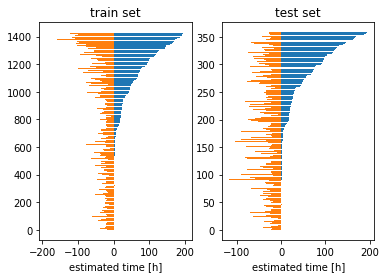

In [54]:
f = plt.figure()


plt.subplot(1,2,1)
plt.title("train set")
idx = np.argsort( train_truth.values ).astype(int)
plt.barh(y=np.arange(0, len(train_truth.values)), width=train_truth.values[idx])
plt.barh(y=np.arange(0, len(train_predictions)),  width=train_predictions[idx]*(-1))
plt.xlabel("estimated time [h]")

plt.subplot(1,2,2)
plt.title("test set")
idx = np.argsort( test_truth.values ).astype(int)
plt.barh(y=np.arange(0, len(test_truth.values)), width=test_truth.values[idx])
plt.barh(y=np.arange(0, len(test_predictions)),  width=test_predictions[idx]*(-1))
plt.xlabel("estimated time [h]")

3. Which words in the description make up for large / small durations?

As you can see from the results, the issuetypes "Bug" and "New Feature" have the largest positive impact on the estimation. On the other end of the spectrum are the "error" and "com", which have the largest negative impact on the estimation. For the top 15 words that cause the highest positive / negative impact, see the figure below.


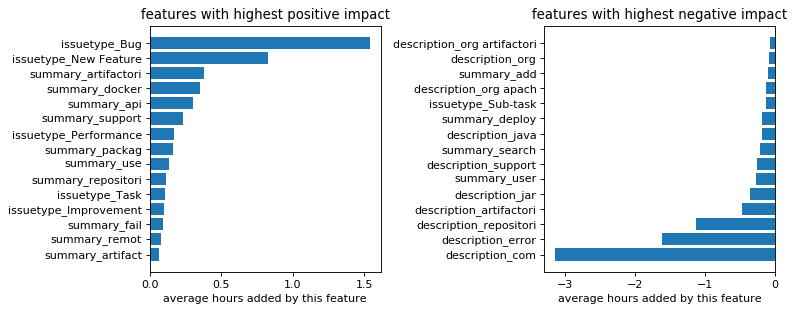

In [55]:
sorted_idx = np.argsort(average_impact_order1).astype(int)

fig=plt.figure(figsize=(10, 4), dpi= 80)

plt.subplot(1,2,1)
plt.title('features with highest positive impact')
top = sorted_idx[-15:]
pos = np.arange(top.shape[0]) + .5
plt.barh(pos, np.array(average_impact_order1)[top], align='center')
plt.yticks(pos, np.array(feature_labels_order1)[top])
plt.xlabel('average hours added by this feature')


plt.subplot(1,2,2)
plt.title('features with highest negative impact')
bottom = sorted_idx[:15]
pos = np.arange(bottom.shape[0]) + .5
plt.barh(pos, np.array(average_impact_order1)[bottom], align='center')
plt.yticks(pos, np.array(feature_labels_order1)[bottom])
plt.xlabel('average hours added by this feature')

plt.tight_layout()